# Urn Task: Bayesian Cognition in LLMs

This notebook tests whether a model behaves like a Bayesian observer on a two-urn sequential inference task.

In [ ]:
# !pip -q install transformer_lens circuitsvis einops pandas numpy matplotlib tqdm scikit-learn huggingface_hub

# Plotly renderer (CircuitVis)
try:
    import plotly.io as pio
    pio.renderers.default = 'notebook_connected'
except Exception as e:
    print('Plotly renderer not set:', e)


In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from transformer_lens import HookedTransformer
from transformer_lens.utils import get_act_name

import circuitsvis as cv
from IPython.display import display

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Determinism (best-effort)
try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

print('Seeds set to', SEED)


Seeds set to 0


In [ ]:
# huggingface login
from huggingface_hub import login

# login()

import os
hf_token = os.getenv('HF_TOKEN', None)
if hf_token:
    login(token=hf_token)
    print('Logged in to Hugging Face')
else:
    print('HF_TOKEN not set. Use interactive login() or set HF_TOKEN environment variable.')


Logged in to Hugging Face


In [ ]:
# global configuration

MODEL_ID = 'meta-llama/Llama-3.2-3B'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float16 if DEVICE == 'cuda' else torch.float32

# Task config
urn_A_pX = 0.75
urn_B_pX = 0.25
prior_P_A = 0.5

seq_len_single = 20
seq_len_batch = 20
n_batch_episodes = 200

prompt_template_version = 'v0'  # v0 | v1 | v2 | v3

# Readout config (forced choice)
ANSWER_TOKEN_A = ' A'
ANSWER_TOKEN_B = ' B'
ANSWER_MEANS = {'A': 'X', 'B': 'Y'}

# Drift config
# drift_readout controls drift metric on prob or logit diff
drift_readout = 'logit_diff'  # 'prob' or 'logit_diff'
drift_counts_total_N = 12
drift_counts_nX = 6
n_permutations = 64
drift_metric = 'std'  # 'std' or 'max-min'

# Head search config
head_search_scope = 'all'  # 'all' or 'layers_subset'
layers_subset = list(range(0, 4))  # used only if scope == 'layers_subset'
top_k_heads_to_report = 30
top_k_heads_to_ablate_default = 5

# Ablation config
heads_to_ablate = []  # fill after seeing ranking
ablate_mode = 'zero'  # 'zero' or 'scale'
ablate_scale = 0.0

# Probe config
probe_target = 'posterior_logodds'  # 'posterior_logodds' or 'predictive_logodds'
probe_act_name = 'resid_post'  # 'resid_post' or 'resid_pre'
probe_position = 'answer_pos'  # last position
probe_train_size = 200
probe_test_size = 100
probe_epochs = 1  # unused for ridge; kept for API parity
probe_lr = 1e-3
probe_weight_decay = 0.0
probe_batch_size = 32
probe_type = 'ridge'  # 'ridge' or 'logistic' (ridge recommended)

# Output
output_dir = 'results_urn_task'
os.makedirs(output_dir, exist_ok=True)

print('MODEL_ID:', MODEL_ID)
print('DEVICE:', DEVICE, 'DTYPE:', DTYPE)
print('Task: A_pX=%.2f B_pX=%.2f prior=%.2f' % (urn_A_pX, urn_B_pX, prior_P_A))
print('Prompt template:', prompt_template_version)
print('Output dir:', output_dir)


MODEL_ID: meta-llama/Llama-3.2-3B
DEVICE: cuda DTYPE: torch.float16
Task: A_pX=0.75 B_pX=0.25 prior=0.50
Prompt template: v1
Output dir: results_urn_task


In [ ]:
# load model with TransformerLens

model = HookedTransformer.from_pretrained(MODEL_ID, device=DEVICE, dtype=DTYPE)
model.eval()

print('Loaded', MODEL_ID)
print('n_layers:', model.cfg.n_layers, 'n_heads:', model.cfg.n_heads, 'd_model:', model.cfg.d_model)
print('tokenizer:', type(model.tokenizer))


config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Llama-3.2-3B into HookedTransformer
Loaded meta-llama/Llama-3.2-3B
n_layers: 28 n_heads: 24 d_model: 3072
tokenizer: <class 'transformers.tokenization_utils_fast.PreTrainedTokenizerFast'>


In [ ]:
# tokenization sanity checks (strict)


def assert_single_token(text):
    ids = model.tokenizer.encode(text, add_special_tokens=False)
    if len(ids) != 1:
        raise RuntimeError(f'Tokenization error: {text!r} is not a single token (ids={ids}). Choose another label.')
    return ids[0]

# Check answer tokens
A_id = assert_single_token(ANSWER_TOKEN_A)
B_id = assert_single_token(ANSWER_TOKEN_B)

print('Chosen answer tokens:')
print('A token:', repr(ANSWER_TOKEN_A), 'id=', A_id, 'decoded=', model.tokenizer.decode([A_id]))
print('B token:', repr(ANSWER_TOKEN_B), 'id=', B_id, 'decoded=', model.tokenizer.decode([B_id]))

# Also check plain A/B for info
for s in ['A','B']:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print('Tokenization for', repr(s), '->', ids)

# Observation symbol tokens (X/Y)
obs_tokens = ['X','Y',' X',' Y']
print('Observation tokenization lengths:')
for s in obs_tokens:
    ids = model.tokenizer.encode(s, add_special_tokens=False)
    print(repr(s), 'len=', len(ids), 'ids=', ids)


Chosen answer tokens:
A token: ' A' id= 362 decoded=  A
B token: ' B' id= 426 decoded=  B
Tokenization for 'A' -> [32]
Tokenization for 'B' -> [33]
Observation tokenization lengths:
'X' len= 1 ids= [55]
'Y' len= 1 ids= [56]
' X' len= 1 ids= [1630]
' Y' len= 1 ids= [816]


In [ ]:
# urn task math engine (ground truth Bayes)


def bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq):
    pA = prior_P_A
    for obs in obs_seq:
        if obs == 'X':
            lik_A = pX_A
            lik_B = pX_B
        else:
            lik_A = 1 - pX_A
            lik_B = 1 - pX_B
        unnorm_A = lik_A * pA
        unnorm_B = lik_B * (1 - pA)
        denom = unnorm_A + unnorm_B
        pA = unnorm_A / denom if denom > 0 else 0.5
    return pA


def bayes_predictive(posterior_P_A, pX_A, pX_B):
    return posterior_P_A * pX_A + (1 - posterior_P_A) * pX_B


def logodds(p):
    p = max(1e-9, min(1 - 1e-9, p))
    return math.log(p / (1 - p))


def compute_truth_table(obs_seq, prior_P_A, pX_A, pX_B, laplace=0.0):
    rows = []
    pA = prior_P_A
    nX = 0
    for t, obs in enumerate(obs_seq, start=1):
        if obs == 'X':
            nX += 1
        pA = bayes_update_posterior(prior_P_A, pX_A, pX_B, obs_seq[:t])
        p_next_X = bayes_predictive(pA, pX_A, pX_B)
        denom = t + 2 * laplace if laplace > 0 else t
        p_hat = (nX + laplace) / denom if denom > 0 else 0.5
        rows.append({
            'step': t,
            'obs': obs,
            'posterior_P_A': pA,
            'bayes_P_next_X': p_next_X,
            'bayes_logodds': logodds(p_next_X),
            'freq_Phat_X': p_hat,
        })
    return pd.DataFrame(rows)

print('Example truth table:')
print(compute_truth_table(['X','Y','X'], prior_P_A, urn_A_pX, urn_B_pX))


Example truth table:
   step obs  posterior_P_A  bayes_P_next_X  bayes_logodds  freq_Phat_X
0     1   X           0.75           0.625       0.510826     1.000000
1     2   Y           0.50           0.500       0.000000     0.500000
2     3   X           0.75           0.625       0.510826     0.666667


In [ ]:
# prompt design (behavioral, not calculation)

TEMPLATES = {
    'v0': (
        'There are two urns that produce X or Y. Urn A is biased toward X, and Urn B is biased toward Y.\n'
        'So far we have seen: {seq}.\n'
        'Next is more likely?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v1': (
        'Two urns produce X/Y. Urn A produces X about {pA_pct:.0f}%% of the time, Urn B produces X about {pB_pct:.0f}%% of the time.\n'
        'Observed sequence: {seq}.\n'
        'Which is more likely next?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v2': (
        'We have two generators. Urn A gives X roughly {pA_pct:.0f}%% of the time; Urn B gives X roughly {pB_pct:.0f}%% of the time.\n'
        'Sequence so far: {seq}.\n'
        'Next is more likely?\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
    'v3': (
        'Urn A tends to give X; Urn B tends to give Y. In numbers: A gives X about {pA_pct:.0f}%%, B gives X about {pB_pct:.0f}%%.\n'
        'Evidence: {seq}.\n'
        'Choose the more likely next symbol.\n'
        'A) X\n'
        'B) Y\n'
        'Answer:'
    ),
}


def build_prompt(obs_seq, pA, pB, prior, template_id='v1'):
    seq_str = ' '.join(obs_seq) if len(obs_seq) > 0 else '(none yet)'
    return TEMPLATES[template_id].format(
        pA=pA,
        pB=pB,
        pA_pct=100 * pA,
        pB_pct=100 * pB,
        prior=prior,
        seq=seq_str,
    )

print(build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

Two urns produce X/Y. Urn A makes X with probability 0.75. Urn B makes X with probability 0.25. Prior P(A)=0.50. Observed sequence: X Y X.Next output is more likely:A) X
B) Y
Answer:


In [ ]:
# extract model belief from logits (forced-choice readout)

@torch.no_grad()
def get_ab_logprobs(prompt_str, token_id_A, token_id_B):
    logits = model(prompt_str)
    last = logits[0, -1, :]
    logit_A = float(last[token_id_A].item())
    logit_B = float(last[token_id_B].item())
    probs = torch.softmax(last.float(), dim=-1)
    pA = float(probs[token_id_A].item())
    pB = float(probs[token_id_B].item())
    denom = pA + pB
    pA_norm = pA / denom if denom > 0 else 0.5
    pB_norm = pB / denom if denom > 0 else 0.5
    logodds_AB = math.log(pA_norm / pB_norm) if pA_norm > 0 and pB_norm > 0 else 0.0
    return {
        'logit_A': logit_A,
        'logit_B': logit_B,
        'pA_norm': pA_norm,
        'pB_norm': pB_norm,
        'logodds_AB': logodds_AB,
    }

prompt = build_prompt(['X','Y','X'], urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
print(get_ab_logprobs(prompt, A_id, B_id))


{'logit_A': 19.34375, 'logit_B': 19.078125, 'pA_norm': 0.5660185235268059, 'pB_norm': 0.43398147647319407, 'logodds_AB': 0.2656249524946193}


,step,obs_t,true_hidden_urn,bayes_P_next_X,model_P_next_X,freq_Phat_X,bayes_logodds,model_logodds
0,1,Y,B,0.375000,0.496094,0.0,-0.510826,-0.015625
1,2,Y,B,0.300000,0.488283,0.0,-0.847298,-0.046875
2,3,Y,B,0.267857,0.488283,0.0,-1.005522,-0.046875
3,4,Y,B,0.256098,0.488283,0.0,-1.066351,-0.046875
4,5,X,B,0.267857,0.527317,0.2,-1.005522,0.109375


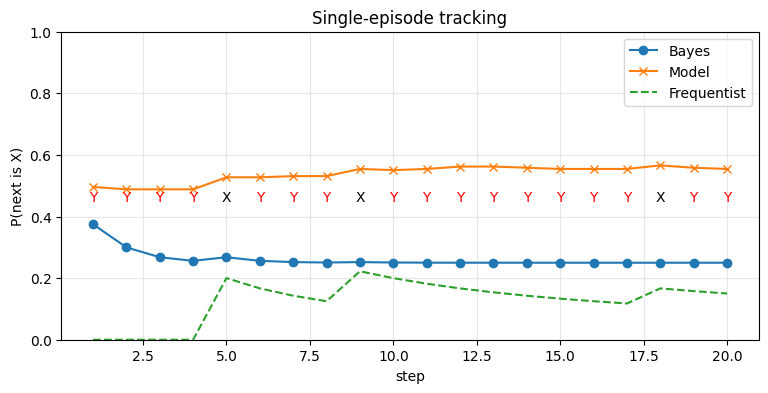

MAE: 0.27668649116825816 Bias: 0.27668649116825816 Corr: -0.6069687836117704


In [ ]:
# single-episode demo (dynamic sequence)

hidden_urn = 'A' if random.random() < prior_P_A else 'B'
true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX

obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_single)]

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    model_out = get_ab_logprobs(prompt, A_id, B_id)

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    bayes_logodds = float(truth.iloc[-1]['bayes_logodds'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'true_hidden_urn': hidden_urn,
        'bayes_P_next_X': bayes_p,
        'model_P_next_X': model_out['pA_norm'],
        'freq_Phat_X': freq_p,
        'bayes_logodds': bayes_logodds,
        'model_logodds': model_out['logodds_AB'],
    })

single_df = pd.DataFrame(rows)
display(single_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(single_df.step, single_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(single_df.step, single_df.model_P_next_X, label='Model', marker='x')
ax.plot(single_df.step, single_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(single_df.obs_t):
    ax.annotate(tok, (single_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode tracking')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae = float((single_df.model_P_next_X - single_df.bayes_P_next_X).abs().mean())
bias = float((single_df.model_P_next_X - single_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(single_df.model_P_next_X, single_df.bayes_P_next_X)[0, 1])
print('MAE:', mae, 'Bias:', bias, 'Corr:', corr)


In [ ]:
# batch evaluation (no ablation)

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        model_out = get_ab_logprobs(prompt, A_id, B_id)

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'ep': ep,
            't': t,
            'bayes_P_next_X': bayes_p,
            'model_P_next_X': model_out['pA_norm'],
        })

all_df = pd.DataFrame(rows)

mae = float((all_df.model_P_next_X - all_df.bayes_P_next_X).abs().mean())
bias = float((all_df.model_P_next_X - all_df.bayes_P_next_X).mean())
corr = float(np.corrcoef(all_df.model_P_next_X, all_df.bayes_P_next_X)[0, 1])

summary = pd.DataFrame([{'MAE': mae, 'Bias': bias, 'Corr': corr, 'n': len(all_df)}])
display(summary)
summary.to_csv(os.path.join(output_dir, 'batch_summary_baseline.csv'), index=False)


episodes:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
# martingale drift setup (permutation invariance test)

base_seq = ['X'] * drift_counts_nX + ['Y'] * (drift_counts_total_N - drift_counts_nX)

perm_seqs = []
perm_prompts = []
rng = np.random.default_rng(SEED)

for _ in range(n_permutations):
    seq = base_seq.copy()
    rng.shuffle(seq)
    perm_seqs.append(seq)
    perm_prompts.append(build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))

preds = []
logit_diffs = []
for prompt in tqdm(perm_prompts, desc='perm eval'):
    out = get_ab_logprobs(prompt, A_id, B_id)
    preds.append(out['pA_norm'])
    logit_diffs.append(out['logit_A'] - out['logit_B'])

perm_df = pd.DataFrame({
    'seq': [' '.join(s) for s in perm_seqs],
    'model_P_next_X': preds,
    'logit_diff_A_minus_B': logit_diffs,
})

if drift_readout == 'prob':
    series = perm_df.model_P_next_X
else:
    series = perm_df.logit_diff_A_minus_B

if drift_metric == 'std':
    drift_val = float(np.std(series))
else:
    drift_val = float(series.max() - series.min())

posterior_P_A = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, base_seq)
bayes_pred = bayes_predictive(posterior_P_A, urn_A_pX, urn_B_pX)

print('Drift metric:', drift_metric, 'value:', drift_val)
print('Bayes predictive P(next=X):', bayes_pred)

perm_df_sorted = perm_df.sort_values('model_P_next_X')
print('Lowest predictions:')
display(perm_df_sorted.head(3))
print('Highest predictions:')
display(perm_df_sorted.tail(3))


perm eval:   0%|          | 0/64 [00:00<?, ?it/s]

Drift metric: std value: 0.01354485061078237
Bayes predictive P(next=X): 0.5000000000000046
Lowest predictions:


,seq,model_P_next_X
16,X X X Y Y Y X X X Y Y Y,0.519521
29,X X X Y Y Y Y X X Y X Y,0.519521
24,X X X Y X Y X Y X Y Y Y,0.527317


Highest predictions:


,seq,model_P_next_X
27,X Y X X Y Y X X Y Y X Y,0.581303
57,X Y X X Y X X Y X Y Y Y,0.585101
59,X Y X X X Y X Y Y Y X Y,0.585101


In [28]:
# head ablation utilities (TransformerLens hooks)

from collections import defaultdict


def make_head_ablation_hooks(head_indices, mode='zero', scale=0.0):
    # head_indices: list of (layer, head) pairs
    layer_to_heads = defaultdict(list)
    for layer, head in head_indices:
        layer_to_heads[int(layer)].append(int(head))

    hooks = []
    for layer, heads in layer_to_heads.items():
        hook_name = f'blocks.{layer}.attn.hook_result'
        heads = sorted(set(heads))

        def hook_fn(act, hook, heads=heads, mode=mode, scale=scale):
            # act: [batch, pos, head, d_head]
            if mode == 'zero':
                act[:, :, heads, :] = 0.0
            elif mode == 'scale':
                act[:, :, heads, :] = act[:, :, heads, :] * scale
            else:
                raise ValueError('Unknown mode')
            return act

        hooks.append((hook_name, hook_fn))
    return hooks


@torch.no_grad()
def get_pA_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    probs = torch.softmax(last.float(), dim=-1)

    pA = probs[:, A_id]
    pB = probs[:, B_id]
    denom = pA + pB
    pA_norm = pA / denom
    return pA_norm.detach().cpu().numpy()




@torch.no_grad()
def get_logitdiff_for_prompts_batch(prompts, hooks=None):
    tokens = model.to_tokens(prompts, prepend_bos=True)
    logits = model(tokens) if hooks is None else model.run_with_hooks(tokens, fwd_hooks=hooks)
    last = logits[:, -1, :]
    logit_diff = (last[:, A_id] - last[:, B_id]).detach().cpu().numpy()
    return logit_diff
def run_model_with_optional_ablation(prompts, heads_to_ablate):
    if heads_to_ablate is None or len(heads_to_ablate) == 0:
        return get_pA_for_prompts_batch(prompts, hooks=None)
    hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
    return get_pA_for_prompts_batch(prompts, hooks=hooks)

print('Ablation utilities ready')


Ablation utilities ready


In [29]:
# identify drift-driving heads by ablation scan

baseline_preds = get_pA_for_prompts_batch(perm_prompts)
if drift_readout == 'prob':
    baseline_series = baseline_preds
else:
    baseline_series = get_logitdiff_for_prompts_batch(perm_prompts)

if drift_metric == 'std':
    drift_baseline = float(np.std(baseline_series))
else:
    drift_baseline = float(baseline_series.max() - baseline_series.min())

print('Baseline drift:', drift_baseline)

if head_search_scope == 'all':
    candidate_layers = list(range(model.cfg.n_layers))
else:
    candidate_layers = list(layers_subset)

rows = []
for layer in tqdm(candidate_layers, desc='layer scan'):
    for head in range(model.cfg.n_heads):
        hooks = make_head_ablation_hooks([(layer, head)], mode='zero')
        preds = get_pA_for_prompts_batch(perm_prompts, hooks=hooks)
        if drift_readout == 'prob':
            series = preds
        else:
            series = get_logitdiff_for_prompts_batch(perm_prompts, hooks=hooks)
        if drift_metric == 'std':
            drift = float(np.std(series))
        else:
            drift = float(series.max() - series.min())
        rows.append({
            'layer': layer,
            'head': head,
            'drift_baseline': drift_baseline,
            'drift_ablated': drift,
            'drift_reduction': drift_baseline - drift,
            'mean_P_next_X_baseline': float(baseline_preds.mean()),
            'mean_P_next_X_ablated': float(preds.mean()),
        })

head_rank = pd.DataFrame(rows).sort_values('drift_reduction', ascending=False)

display(head_rank.head(top_k_heads_to_report))

head_rank.to_csv(os.path.join(output_dir, 'head_drift_ranking.csv'), index=False)


Baseline drift: 0.013993144035339355


layer scan:   0%|          | 0/28 [00:00<?, ?it/s]

,layer,head,drift_baseline,drift_ablated,drift_reduction,mean_P_next_X_baseline,mean_P_next_X_ablated
0,0,0,0.013993,0.013993,0.0,0.559065,0.559065
451,18,19,0.013993,0.013993,0.0,0.559065,0.559065
443,18,11,0.013993,0.013993,0.0,0.559065,0.559065
444,18,12,0.013993,0.013993,0.0,0.559065,0.559065
445,18,13,0.013993,0.013993,0.0,0.559065,0.559065
446,18,14,0.013993,0.013993,0.0,0.559065,0.559065
447,18,15,0.013993,0.013993,0.0,0.559065,0.559065
448,18,16,0.013993,0.013993,0.0,0.559065,0.559065
449,18,17,0.013993,0.013993,0.0,0.559065,0.559065
450,18,18,0.013993,0.013993,0.0,0.559065,0.559065


In [ ]:
# choose heads to ablate

# manual selection
# heads_to_ablate = []

# auto-fill with top-K heads
heads_to_ablate = [(int(r.layer), int(r.head)) for r in head_rank.head(top_k_heads_to_ablate_default).itertuples()]

print('heads_to_ablate:', heads_to_ablate)


heads_to_ablate: [(0, 0), (18, 19), (18, 11), (18, 12), (18, 13)]


,step,obs_t,bayes_P_next_X,model_P_next_X_base,model_P_next_X_ablated,freq_Phat_X
0,1,Y,0.375,0.496094,0.496094,0.000000
1,2,Y,0.300,0.488283,0.488283,0.000000
2,3,X,0.375,0.538983,0.538983,0.333333
3,4,X,0.500,0.542863,0.542863,0.500000
4,5,Y,0.375,0.538983,0.538983,0.400000


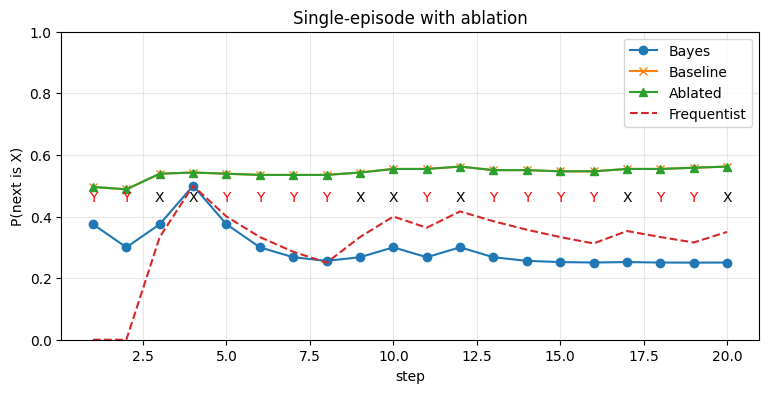

Baseline MAE: 0.24668064614755125 Bias: 0.24668064614755125
Ablated MAE: 0.24668064614755125 Bias: 0.24668064614755125


In [31]:
# single-episode demo with ablation (baseline vs ablated vs Bayes)

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])
    freq_p = float(truth.iloc[-1]['freq_Phat_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'model_P_next_X_base': base['pA_norm'],
        'model_P_next_X_ablated': abl,
        'freq_Phat_X': freq_p,
    })

abl_df = pd.DataFrame(rows)
display(abl_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(abl_df.step, abl_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(abl_df.step, abl_df.model_P_next_X_base, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(abl_df.step, abl_df.model_P_next_X_ablated, label='Ablated', marker='^')
ax.plot(abl_df.step, abl_df.freq_Phat_X, label='Frequentist', linestyle='--')

for i, tok in enumerate(abl_df.obs_t):
    ax.annotate(tok, (abl_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with ablation')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

mae_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).abs().mean())
bias_base = float((abl_df.model_P_next_X_base - abl_df.bayes_P_next_X).mean())

print('Baseline MAE:', mae_base, 'Bias:', bias_base)
if heads_to_ablate:
    mae_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).abs().mean())
    bias_abl = float((abl_df.model_P_next_X_ablated - abl_df.bayes_P_next_X).mean())
    print('Ablated MAE:', mae_abl, 'Bias:', bias_abl)


In [32]:
# batch evaluation with ablation (baseline vs ablated)

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']

        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'model_P_next_X_base': base,
            'model_P_next_X_ablated': abl,
        })

all_df2 = pd.DataFrame(rows)

summary_rows = []
mae_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).abs().mean())
bias_base = float((all_df2.model_P_next_X_base - all_df2.bayes_P_next_X).mean())
corr_base = float(np.corrcoef(all_df2.model_P_next_X_base, all_df2.bayes_P_next_X)[0, 1])
summary_rows.append({'model': 'baseline', 'MAE': mae_base, 'Bias': bias_base, 'Corr': corr_base})

if heads_to_ablate:
    mae_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).abs().mean())
    bias_abl = float((all_df2.model_P_next_X_ablated - all_df2.bayes_P_next_X).mean())
    corr_abl = float(np.corrcoef(all_df2.model_P_next_X_ablated, all_df2.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': 'ablated', 'MAE': mae_abl, 'Bias': bias_abl, 'Corr': corr_abl})

summary = pd.DataFrame(summary_rows)
display(summary)

base_preds = get_pA_for_prompts_batch(perm_prompts)
if drift_readout == 'prob':
    base_series = base_preds
else:
    base_series = get_logitdiff_for_prompts_batch(perm_prompts)

if drift_metric == 'std':
    drift_base = float(np.std(base_series))
else:
    drift_base = float(base_series.max() - base_series.min())

if heads_to_ablate:
    ablated_preds = run_model_with_optional_ablation(perm_prompts, heads_to_ablate)
    if drift_readout == 'prob':
        ablated_series = ablated_preds
    else:
        ablated_series = get_logitdiff_for_prompts_batch(perm_prompts, hooks=make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale))
    if drift_metric == 'std':
        drift_abl = float(np.std(ablated_series))
    else:
        drift_abl = float(ablated_series.max() - ablated_series.min())
    print('Drift baseline:', drift_base, 'Drift ablated:', drift_abl, 'Reduction:', drift_base - drift_abl)

summary.to_csv(os.path.join(output_dir, 'batch_summary_ablation.csv'), index=False)


episodes:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# circuitVis attention visualization (baseline and ablated)

min_seq = perm_df_sorted.head(1).iloc[0]['seq'].split(' ')
max_seq = perm_df_sorted.tail(1).iloc[0]['seq'].split(' ')

for label, seq in [('min', min_seq), ('max', max_seq)]:
    prompt = build_prompt(seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
    print('===', label, 'prompt ===')
    print(prompt)
    logits, cache = model.run_with_cache(prompt)
    tokens = model.to_str_tokens(prompt)
    for layer in range(model.cfg.n_layers):
        patt = cache['pattern', layer][0].detach().cpu().numpy()
        display(cv.attention.attention_patterns(tokens=tokens, attention=patt, title=f'{label}: layer {layer} (baseline)'))

    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits2, cache2 = model.run_with_cache(prompt, fwd_hooks=hooks)
        for layer in range(model.cfg.n_layers):
            patt2 = cache2['pattern', layer][0].detach().cpu().numpy()
            display(cv.attention.attention_patterns(tokens=tokens, attention=patt2, title=f'{label}: layer {layer} (ablated)'))

print('Note: ablation changes outputs; attention patterns may be similar.')


In [ ]:
# build probe dataset (activations + labels)

from collections import defaultdict


def generate_episode(pA, pB, prior, length):
    hidden = 'A' if random.random() < prior else 'B'
    pX = pA if hidden == 'A' else pB
    obs = ['X' if random.random() < pX else 'Y' for _ in range(length)]
    return hidden, obs


def get_target_logodds(obs_prefix):
    pA = bayes_update_posterior(prior_P_A, urn_A_pX, urn_B_pX, obs_prefix)
    if probe_target == 'posterior_logodds':
        return logodds(pA)
    p_next = bayes_predictive(pA, urn_A_pX, urn_B_pX)
    return logodds(p_next)


def batch_by_length(prompts):
    groups = defaultdict(list)
    for i, p in enumerate(prompts):
        length = len(model.tokenizer.encode(p, add_special_tokens=False)) + 1
        groups[length].append(i)
    return groups

train_prompts = []
train_labels = []

for _ in range(probe_train_size):
    _, obs = generate_episode(urn_A_pX, urn_B_pX, prior_P_A, seq_len_batch)
    for t in range(1, seq_len_batch + 1):
        prefix = obs[:t]
        train_prompts.append(build_prompt(prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version))
        train_labels.append(get_target_logodds(prefix))

train_labels = np.array(train_labels, dtype=np.float32)

X_by_layer = {layer: [] for layer in range(model.cfg.n_layers)}
idx_groups = batch_by_length(train_prompts)

for length, idxs in tqdm(idx_groups.items(), desc='probe extract (train)'):
    batch_prompts = [train_prompts[i] for i in idxs]
    tokens = model.to_tokens(batch_prompts, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    for layer in range(model.cfg.n_layers):
        act = cache[probe_act_name, layer][:, -1, :].detach().cpu().numpy()
        X_by_layer[layer].append(act)

for layer in X_by_layer:
    X_by_layer[layer] = np.concatenate(X_by_layer[layer], axis=0)

print('Probe dataset shape example:', X_by_layer[0].shape, 'labels:', train_labels.shape)


In [ ]:
# train linear probes for all layers

from sklearn.linear_model import Ridge

results = []
probe_weights = {}

n_total = len(train_labels)
idx = np.arange(n_total)
np.random.shuffle(idx)
split = int(0.8 * n_total)
train_idx, test_idx = idx[:split], idx[split:]

for layer in tqdm(range(model.cfg.n_layers), desc='probe train'):
    X = X_by_layer[layer]
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = train_labels[train_idx], train_labels[test_idx]

    if probe_type == 'ridge':
        reg = Ridge(alpha=1.0, fit_intercept=True)
        reg.fit(X_tr, y_tr)
        w = reg.coef_
        b = float(reg.intercept_)
    else:
        raise ValueError('Only ridge implemented in this notebook')

    pred = X_te @ w + b
    pred_p = 1 / (1 + np.exp(-pred))
    true_p = 1 / (1 + np.exp(-y_te))

    mae = float(np.mean(np.abs(pred_p - true_p)))
    mse = float(np.mean((pred - y_te) ** 2))
    corr = float(np.corrcoef(pred_p, true_p)[0, 1])

    results.append({'layer': layer, 'MAE': mae, 'MSE_logodds': mse, 'Corr': corr})
    probe_weights[layer] = (w, b)

    np.save(os.path.join(output_dir, f'probe_w_layer{layer}.npy'), w.astype(np.float32))
    np.save(os.path.join(output_dir, f'probe_b_layer{layer}.npy'), np.array([b], dtype=np.float32))

res_df = pd.DataFrame(results).sort_values('MAE')
display(res_df.head(10))
res_df.to_csv(os.path.join(output_dir, 'probe_results.csv'), index=False)


In [ ]:
# choose probe layer and run single-episode with probe overlay

chosen_probe_layer = int(res_df.iloc[0]['layer'])

w = np.load(os.path.join(output_dir, f'probe_w_layer{chosen_probe_layer}.npy'))
b = float(np.load(os.path.join(output_dir, f'probe_b_layer{chosen_probe_layer}.npy'))[0])

rows = []
for t in range(1, seq_len_single + 1):
    obs_prefix = obs_seq[:t]
    prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

    base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
    abl = None
    if heads_to_ablate:
        hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
        logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
        last = logits[0, -1, :]
        probs = torch.softmax(last.float(), dim=-1)
        pA = float(probs[A_id].item())
        pB = float(probs[B_id].item())
        abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

    tokens = model.to_tokens(prompt, prepend_bos=True)
    logits, cache = model.run_with_cache(tokens)
    act = cache[probe_act_name, chosen_probe_layer][0, -1, :].detach().cpu().numpy()
    pred_logodds = act @ w + b
    probe_p = 1 / (1 + np.exp(-pred_logodds))

    truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
    bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

    rows.append({
        'step': t,
        'obs_t': obs_prefix[-1],
        'bayes_P_next_X': bayes_p,
        'baseline_P_next_X': base,
        'ablated_P_next_X': abl,
        'probe_P_next_X': float(probe_p),
    })

probe_df = pd.DataFrame(rows)
display(probe_df.head())

fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(probe_df.step, probe_df.bayes_P_next_X, label='Bayes', marker='o')
ax.plot(probe_df.step, probe_df.baseline_P_next_X, label='Baseline', marker='x')
if heads_to_ablate:
    ax.plot(probe_df.step, probe_df.ablated_P_next_X, label='Ablated', marker='^')
ax.plot(probe_df.step, probe_df.probe_P_next_X, label='Probe', marker='s')

for i, tok in enumerate(probe_df.obs_t):
    ax.annotate(tok, (probe_df.step.iloc[i], 0.45), fontsize=10, ha='center',
                color='black' if tok == 'X' else 'red')

ax.set_title('Single-episode with probe overlay')
ax.set_xlabel('step')
ax.set_ylabel('P(next is X)')
ax.set_ylim(0.0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

for name in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((probe_df[name] - probe_df.bayes_P_next_X).abs().mean())
    bias = float((probe_df[name] - probe_df.bayes_P_next_X).mean())
    print(name, 'MAE', mae, 'Bias', bias)


In [ ]:
# batch evaluation including probe

rows = []
for ep in tqdm(range(n_batch_episodes), desc='episodes'):
    hidden_urn = 'A' if random.random() < prior_P_A else 'B'
    true_pX = urn_A_pX if hidden_urn == 'A' else urn_B_pX
    obs_seq_batch = ['X' if random.random() < true_pX else 'Y' for _ in range(seq_len_batch)]

    for t in range(1, seq_len_batch + 1):
        obs_prefix = obs_seq_batch[:t]
        prompt = build_prompt(obs_prefix, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

        base = get_ab_logprobs(prompt, A_id, B_id)['pA_norm']
        abl = None
        if heads_to_ablate:
            hooks = make_head_ablation_hooks(heads_to_ablate, mode=ablate_mode, scale=ablate_scale)
            logits = model.run_with_hooks(prompt, fwd_hooks=hooks)
            last = logits[0, -1, :]
            probs = torch.softmax(last.float(), dim=-1)
            pA = float(probs[A_id].item())
            pB = float(probs[B_id].item())
            abl = pA / (pA + pB) if (pA + pB) > 0 else 0.5

        tokens = model.to_tokens(prompt, prepend_bos=True)
        logits, cache = model.run_with_cache(tokens)
        act = cache[probe_act_name, chosen_probe_layer][0, -1, :].detach().cpu().numpy()
        pred_logodds = act @ w + b
        probe_p = 1 / (1 + np.exp(-pred_logodds))

        truth = compute_truth_table(obs_prefix, prior_P_A, urn_A_pX, urn_B_pX)
        bayes_p = float(truth.iloc[-1]['bayes_P_next_X'])

        rows.append({
            'bayes_P_next_X': bayes_p,
            'baseline_P_next_X': base,
            'ablated_P_next_X': abl,
            'probe_P_next_X': float(probe_p),
        })

all_df3 = pd.DataFrame(rows)

summary_rows = []
for col in ['baseline_P_next_X', 'probe_P_next_X']:
    mae = float((all_df3[col] - all_df3.bayes_P_next_X).abs().mean())
    bias = float((all_df3[col] - all_df3.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df3[col], all_df3.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

if heads_to_ablate:
    col = 'ablated_P_next_X'
    mae = float((all_df3[col] - all_df3.bayes_P_next_X).abs().mean())
    bias = float((all_df3[col] - all_df3.bayes_P_next_X).mean())
    corr = float(np.corrcoef(all_df3[col], all_df3.bayes_P_next_X)[0, 1])
    summary_rows.append({'model': col, 'MAE': mae, 'Bias': bias, 'Corr': corr})

summary = pd.DataFrame(summary_rows)
display(summary)
summary.to_csv(os.path.join(output_dir, 'batch_summary_with_probe.csv'), index=False)


In [ ]:
# belief editing and belief swapping (causal validation)
layer_to_edit = chosen_probe_layer
edit_lambda = 5.0

probe_dir = w / (np.linalg.norm(w) + 1e-8)
probe_dir_t = torch.tensor(probe_dir, device=DEVICE, dtype=torch.float32)


def belief_edit_hook(act, hook, direction, scale):
    act[:, -1, :] = act[:, -1, :] + scale * direction
    return act

example_seq = ['X','Y','X','Y','X','Y']
example_prompt = build_prompt(example_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

base = get_ab_logprobs(example_prompt, A_id, B_id)['pA_norm']

if probe_act_name == 'resid_post':
    hook_name = f'blocks.{layer_to_edit}.hook_resid_post'
elif probe_act_name == 'resid_pre':
    hook_name = f'blocks.{layer_to_edit}.hook_resid_pre'
else:
    raise ValueError('Unsupported probe_act_name for editing')

logits = model.run_with_hooks(example_prompt, fwd_hooks=[(hook_name, lambda act, hook: belief_edit_hook(act, hook, probe_dir_t, edit_lambda))])
last = logits[0, -1, :]
probs = torch.softmax(last.float(), dim=-1)
edit_pA = float(probs[A_id].item())
edit_pB = float(probs[B_id].item())
edit = edit_pA / (edit_pA + edit_pB) if (edit_pA + edit_pB) > 0 else 0.5

print('Baseline P(X):', base)
print('Edited   P(X):', edit, '(lambda=', edit_lambda, ')')
print('Belief swapping is left as an exercise: patch the probe component between two runs.')


# Causal validation: belief-subspace patching (necessity & sufficiency)


In [ ]:
# Use probe weight vector w at PROBE_LAYER as a belief direction.
# Define belief subspace:
#   - simplest: 1D direction v = normalize(w)
#   - optional: use top-k probe directions if decoding multi-d belief vector
#
# Sufficiency test (belief swap):
#   - pick two prefixes at same t with different true z_t (or different H)
#   - run both to cache resid at PROBE_LAYER, position=-1
#   - patch only the projection onto v:
#       r_clean <- r_clean - proj_v(r_clean) + proj_v(r_other)
#   - run forward with hooks from that point onward and measure P_A_next shift
#   - check: does output move toward the donor's Bayes posterior predictive?
#
# Necessity test (belief removal):
#   - project out v (remove belief component) and re-run
#   - expect degraded Bayes alignment and/or collapse toward a heuristic baseline
#
# Report effect sizes:
#   - delta logit diff (A-B)
#   - KL between model predictive and Bayes predictive (binary KL)
#   - consistency under repeated trials
#
# Provide user parameters:
#   PATCH_LAYER, PATCH_MODE ("swap", "remove", "edit"), DELTA_STRENGTH

# --- parameters ---
PATCH_LAYER = chosen_probe_layer
PATCH_MODE = 'swap'  # 'swap' | 'remove' | 'edit'
DELTA_STRENGTH = 1.0

# --- helpers ---
import numpy as np
import torch

v = w / (np.linalg.norm(w) + 1e-8)
v_t = torch.tensor(v, device=DEVICE, dtype=torch.float32)


def proj_v(x, v):
    # x: [d_model], v: [d_model]
    return (x @ v) * v


def patch_resid_fn(resid, hook, v, mode, donor_resid=None, delta=1.0):
    # resid: [batch, pos, d_model]
    r = resid[:, -1, :]
    if mode == 'remove':
        r = r - proj_v(r, v)
    elif mode == 'edit':
        r = r + delta * v
    elif mode == 'swap':
        if donor_resid is None:
            raise ValueError('donor_resid required for swap')
        r = r - proj_v(r, v) + proj_v(donor_resid, v)
    else:
        raise ValueError('Unknown PATCH_MODE')
    resid[:, -1, :] = r
    return resid

# TODO: build two prompts with different evidence at same t
# TODO: capture resid at PATCH_LAYER for both, then run patched forward
# TODO: compute delta logit diff + binary KL vs Bayes


# Causal validation: forced belief edits + update coherence


In [ ]:
# Belief edit:
#   - add +/-lambda v to the residual at PATCH_LAYER
#   - measure monotonic effect on P_A_next (dose-response curve over lambda)
#
# Update coherence test:
#   - after editing belief at time t, append 1-3 additional observations and re-query,
#     verifying that subsequent updates follow Bayes-like dynamics from the edited starting point
#     (this tests "belief is actually the state the updater uses," not a dead correlational feature).

LAMBDA_GRID = [-10, -5, -2, -1, 0, 1, 2, 5, 10]

# TODO: pick a base prompt (obs_prefix)
# TODO: apply edit hook at PATCH_LAYER with each lambda
# TODO: record P_A_next vs lambda and plot
# TODO: append additional observations and check update coherence vs Bayes


# (Optional but recommended) Path patching / edge attribution for update vs readout


In [ ]:
# (Optional but recommended) Path patching / edge attribution for update vs readout

# (1) Write-to-logits attribution
u = model.W_U[:, A_id] - model.W_U[:, B_id]  # unembedding direction

# Choose a representative prompt from drift extremes if available
if 'perm_df_sorted' in globals():
    min_seq = perm_df_sorted.head(1).iloc[0]['seq'].split(' ')
    max_seq = perm_df_sorted.tail(1).iloc[0]['seq'].split(' ')
else:
    min_seq = ['Y'] * drift_counts_total_N
    max_seq = ['X'] * drift_counts_total_N

prompt = build_prompt(max_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
logits, cache = model.run_with_cache(prompt)

rows = []
for layer in range(model.cfg.n_layers):
    head_out = cache['attn.hook_result', layer][0, -1, :, :]  # [head, d_model]
    for head in range(model.cfg.n_heads):
        contrib = float((head_out[head] @ u).item())
        rows.append({'layer': layer, 'head': head, 'contrib_to_logit_diff': contrib})

attr_df = pd.DataFrame(rows).sort_values('contrib_to_logit_diff', ascending=False)
print('Top positive contributors:')
display(attr_df.head(10))
print('Top negative contributors:')
display(attr_df.tail(10))

# (2) Path patching (clean -> corrupt) using head outputs
PATCH_LAYER_RANGE = list(range(model.cfg.n_layers))  # full scan for rigor

clean_seq = ['X'] * (drift_counts_total_N)  # evidence for urn A
corrupt_seq = ['Y'] * (drift_counts_total_N)  # evidence for urn B

clean_prompt = build_prompt(clean_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)
corrupt_prompt = build_prompt(corrupt_seq, urn_A_pX, urn_B_pX, prior_P_A, prompt_template_version)

clean_logits, clean_cache = model.run_with_cache(clean_prompt)
corrupt_logits, corrupt_cache = model.run_with_cache(corrupt_prompt)

clean_ld = readout_from_logits(clean_logits)['logit_diff']
corrupt_ld = readout_from_logits(corrupt_logits)['logit_diff']

patch_rows = []
for layer in PATCH_LAYER_RANGE:
    hook_name = f'blocks.{layer}.attn.hook_result'
    for head in range(model.cfg.n_heads):
        def hook_fn(act, hook, head=head, layer=layer):
            act[:, :, head, :] = clean_cache[hook_name][:, :, head, :]
            return act
        patched_logits = model.run_with_hooks(corrupt_prompt, fwd_hooks=[(hook_name, hook_fn)])
        patched_ld = readout_from_logits(patched_logits)['logit_diff']
        patch_rows.append({
            'layer': layer,
            'head': head,
            'clean_ld': clean_ld,
            'corrupt_ld': corrupt_ld,
            'patched_ld': patched_ld,
            'recovery': patched_ld - corrupt_ld,
        })

patch_df = pd.DataFrame(patch_rows).sort_values('recovery', ascending=False)
print('Top patch-recovery heads:')
display(patch_df.head(10))


# Invariance & robustness suite (avoid prompt artifacts)


In [ ]:
# Run the same evaluation metrics under:
#   - symbol swap: swap meaning of A and B in both urn definitions and observations
#   - paraphrase: multiple prompt templates with same underlying task
#   - distractors: irrelevant narrative sentences injected
#   - parameter generalization: different urn compositions (not just 75/50)
#
# Report:
#   - Bayes fit metrics
#   - drift metrics
#   - probe generalization metrics (does PROBE_LAYER still decode?)

# TODO: implement robustness sweeps and summary tables
